# Sistema CSTR

Este cuaderno se estudia el sistema discutido en Seborg, Edgar, Melichamp & Doyle "Process Dynamics and Control" (3rd Ed).

```{figure} cstr.png
:name: cstr
:width: 400px
:alt: cstr
:align: center

Reactor continuo de tanque agitado
```

## Modelo

$$
\begin{align}
k &= k_0\exp\left(\frac{-E}{RT}\right)\\
w &=q\rho \\
V\frac{\mathrm{d}c_A}{\mathrm{d}t} &= q(c_{Ai} - c_A) - V k c_A \\
V\rho C\frac{\mathrm{d}T}{\mathrm{d}t} &= wC(T_i - T) + (-\Delta H_R) V k c_A + UA(T_c - T)qc
\end{align}
$$

Balance de Energía:

$$\frac{dE}{dt} = E_{in} - E_{out}$$

Balance de Masa:

$$\frac{dm}{dt} = \dot m_{in} - \dot m_{out}$$

Balance de composición:

$$\frac{dN_A}{dt} = N_{A,in} - N_{A, out} + N_{A, \text{gen}} - N_{A, \text{consumed}}$$

### Descripción

El modelo dinámico del sistema anterior se módifico levenmente para que se manipule el caudal de entrada de refrigerante y no la temperatura como figura en el diagrama. 

El objetivo de conrol de esta planta es lograr mantener la temperatura constante de la reacción a pesar de los cambios en la composición de caudal de entrada al reactor.

In [4]:
import control as ctrl
import numpy as np
import matplotlib.pyplot as plt

In [5]:
cA0 = 0.5  # mol/L
T0 = 350  # K 

In [6]:
def derivs_CSTR(t, x, u, params):
    
    q = params.get('q', 100)   # L/min 
    # cA_i = params.get('cAi', 1)  # mol/L
    T_i = params.get('T_i', 350)  # K 
    V = params.get('V', 100)  # L
    rho = params.get('rho', 1000) # g/L
    C = params.get('C', 0.239) # J/(g K)
    Hr = params.get('Hr', -5e4)  # J/(g K)
    E_over_R = params.get('E_over_R', 8750)  # K
    k0 = params.get('ko', 7.2e10)   # 1/min
    UA = params.get('UA', 5e2)  # J/(L K)
    Tc = params.get('Tc', 300)  # K
    
    qc, cA_i= u 
    cA, T = x
    
    k = k0*np.exp(-E_over_R/T)
    w = q*rho
    dcAdt = q*(cA_i - cA)/V - k*cA
    dTdt = 1/(V*rho*C)*(w*C*(T_i - T) - Hr*V*k*cA + UA*(Tc - T)*qc)
    return dcAdt, dTdt

def outputs_CSTR(t, x, u, params):
    return x[0], x[1]
    


In [7]:
CSTR_sys=ctrl.NonlinearIOSystem(derivs_CSTR, 
                                outputs_CSTR, 
                                inputs=('Tc', 'CA_i'), 
                                outputs=('cA', 'T'), 
                                states=('dcA', 'dT'))

In [57]:
T = np.linspace(0, 10, 3000)
x0 = [cA0, T0]

def Usignal(T):
    U = np.zeros((2, len(T)))
    for i, t in enumerate(T):
        U[0,i] = 105 if t>1 else 100 
        U[1,i] = 1 if t >1 else 1
        
    return U

U=Usignal(T)

In [58]:
t,y = ctrl.input_output_response(CSTR_sys, T, U, x0)

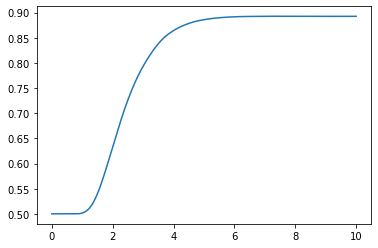

In [59]:
plt.plot(t,y[0,:])